### Naive Semantic Chunker

In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import re

from rich.console import Console
from rich.table import Table
from rich.panel import Panel

console = Console()

In [2]:
def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

In [3]:
def naive_semantic_chunking(
    text: str,
    threshold: float = 0.75,
    model_name: str = "all-MiniLM-L6-v2"
):
    """
    Level 0 — Naive baseline semantic chunking.
    DO NOT use in production. This is for understanding only.
    """

    console.rule("[bold red]Level 0 — Naive Semantic Chunking (What NOT to do)")

    # ------------------------------------------------------------------
    # Step 1: Sentence splitting (very naive)
    # ------------------------------------------------------------------
    sentences = [
        s.strip()
        for s in re.split(r"(?<=[.!?])\s+", text)
        if s.strip()
    ]

    # ------------------------------------------------------------------
    # Step 2: Embeddings (single sentence, no windowing)
    # ------------------------------------------------------------------
    model = SentenceTransformer(model_name)
    embeddings = model.encode(sentences, normalize_embeddings=False)

    # ------------------------------------------------------------------
    # Step 3: Show sentences + embeddings
    # ------------------------------------------------------------------
    sent_table = Table(title="Sentences and Embeddings", show_lines=True)
    sent_table.add_column("Index", justify="right")
    sent_table.add_column("Sentence")
    sent_table.add_column("Embedding (first 6 dims)")

    for i, (s, e) in enumerate(zip(sentences, embeddings)):
        sent_table.add_row(
            str(i),
            s,
            np.array2string(e[:6], precision=3, suppress_small=True)
        )

    console.print(sent_table)

    # ------------------------------------------------------------------
    # Step 4: Similarities + thresholding
    # ------------------------------------------------------------------
    sim_table = Table(
        title=f"Cosine Similarities (Threshold = {threshold})",
        show_lines=True
    )
    sim_table.add_column("Pair")
    sim_table.add_column("Similarity", justify="right")
    sim_table.add_column("Below Threshold?")
    sim_table.add_column("BREAK")

    breakpoints = []

    for i in range(len(embeddings) - 1):
        sim = cosine_similarity(embeddings[i], embeddings[i + 1])
        below = sim < threshold
        breakpoints.append(below)

        sim_table.add_row(
            f"S{i} → S{i+1}",
            f"{sim:.4f}",
            "YES" if below else "NO",
            "🔴 BREAK" if below else ""
        )

    console.print(sim_table)

    # ------------------------------------------------------------------
    # Step 5: Final chunks
    # ------------------------------------------------------------------
    chunks = []
    current_chunk = [sentences[0]]

    for i, is_break in enumerate(breakpoints):
        if is_break:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentences[i + 1]]
        else:
            current_chunk.append(sentences[i + 1])

    chunks.append(" ".join(current_chunk))

    # ------------------------------------------------------------
    # Step 6: Display final chunks
    # ------------------------------------------------------------
    for i, chunk in enumerate(chunks):
        console.print(
            Panel(
                chunk,
                title=f"Chunk {i}",
                expand=False
            )
        )



In [4]:
text = """
MEDUSA
Jelly-fish
Whole face puffed œdematous-eyes, nose, ears, lips.
Skin.––Numbness; burning, pricking heat. Vesicular eruption especially on face, arms, shoulders, and breasts. Nettlerash (Apis; Chloral; Dulc).
Female.––Marked action on lacteal glands. The secretion of milk was established after lack of it in all previous confinements.
Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep.

MEL CUM SALE
Honey with Salt
Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from ileum to ileum.
Uterine displacements, and in the commencement of metritis Sensation as if bladder were too full. Pain from sacrum towards pubes. Pain as if in ureters.
Dose.––Third to sixth potency. Honey for itching of anus and worms.

METHYLENUM COERULEUM
Aniline Dye
Methylene Blue
A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; pus infection. Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal nephritis. Urine acquires a green color. Bladder irritation from its use antidoted by a little nutmeg.
Surgical kidney with large amount of pus in urine. Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states of apoplexy (Gisevius).
Dose.––3x attenuation. A 2 per cent solution locally, in chronic otitis with foul smelling discharge.
A 1 per cent aqueous solution for ulcers and abscesses of cornea.
"""

naive_semantic_chunking(text, threshold=0.75)


─────────────────────────────── Level 0 — Naive Semantic Chunking (What NOT to do) ────────────────────────────────

                                             Sentences and Embeddings                                              
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Index ┃ Sentence                                                  ┃ Embedding (first 6 dims)                    ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     0 │ MEDUSA                                                    │ [ 0.008 -0.014  0.035 -0.027 -0.109  0.019] │
│       │ Jelly-fish                                                │                                             │
│       │ Whole face puffed œdematous-eyes, nose, ears, lips.       │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     1 │ Skin.––Numbness; burning, pricking heat.                  │ [ 0.019 -0.023  0.028  0.099  0.012 -0.007] │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     2 │ Vesicular eruption especially on face, arms, shoulders,   │ [ 0.022 -0.024  0.022  0.033 -0.038 -0.067] │
│       │ and breasts.                                              │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     3 │ Nettlerash (Apis; Chloral; Dulc).                         │ [-0.101  0.009 -0.078 -0.098 -0.008 -0.002] │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     4 │ Female.––Marked action on lacteal glands.                 │ [ 0.056 -0.135  0.017  0.019  0.039  0.049] │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     5 │ The secretion of milk was established after lack of it in │ [-0.01  -0.008  0.007  0.092  0.054  0.04 ] │
│       │ all previous confinements.                                │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     6 │ Relationship.––Compare: Pyrarara, Physalia (urticaria);   │ [ 0.024 -0.049 -0.021 -0.055 -0.046  0.029] │
│       │ Urtica, Homar, Sep.                                       │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     7 │ MEL CUM SALE                                              │ [-0.028 -0.02   0.044 -0.008 -0.081  0.084] │
│       │ Honey with Salt                                           │                                             │
│       │ Prolapsus uteri and chronic metritis, especially when     │                                             │
│       │ associated with subinvolution and inflammation of the     │                                             │
│       │ cervix.                                                   │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     8 │ The special symptom leading to its selection is a feeling │ [ 0.079 -0.05  -0.003  0.091 -0.    -0.049] │
│       │ of soreness across the hypogastrium from ileum to ileum.  │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     9 │ Uterine displacements, and in the commencement of         │ [-0.012 -0.102  0.051  0.097 -0.036 -0.07 ] │
│       │ metritis Sensation as if bladder were too full.           │                                             │
├───────┼───────────────────────────────────────────────

         Cosine Similarities (Threshold = 0.75)         
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ Below Threshold? ┃ BREAK    ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S1 → S2   │     0.4403 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S2 → S3   │     0.0192 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S3 → S4   │     0.0852 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S4 → S5   │     0.3052 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S5 → S6   │     0.0378 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S6 → S7   │     0.2145 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S7 → S8   │     0.2816 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S8 → S9   │     0.4499 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S9 → S10  │     0.4174 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S10 → S11 │     0.5411 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S11 → S12 │     0.2616 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S12 → S13 │     0.1467 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S13 → S14 │     0.3779 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S14 → S15 │     0.1279 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S15 → S16 │     0.2231 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S16 → S17 │     0.1720 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S17 → S18 │     0.3420 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S18 → S19 │     0.4766 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S19 → S20 │     0.2057 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S20 → S21 │     0.3742 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S21 → S22 │     0.2566 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S22 → S23 │     0.2661 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S23 → S24 │     0.2048 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S24 → S25 │     0.3949 │ YES              │ 🔴 BREAK │
└───────────┴────────────┴──────────────────┴──────────┘

╭────────────────────── Chunk 0 ──────────────────────╮
│ MEDUSA                                              │
│ Jelly-fish                                          │
│ Whole face puffed œdematous-eyes, nose, ears, lips. │
╰─────────────────────────────────────────────────────╯

╭──────────────── Chunk 1 ─────────────────╮
│ Skin.––Numbness; burning, pricking heat. │
╰──────────────────────────────────────────╯

╭────────────────────────────── Chunk 2 ───────────────────────────────╮
│ Vesicular eruption especially on face, arms, shoulders, and breasts. │
╰──────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 3 ─────────────╮
│ Nettlerash (Apis; Chloral; Dulc). │
╰───────────────────────────────────╯

╭───────────────── Chunk 4 ─────────────────╮
│ Female.––Marked action on lacteal glands. │
╰───────────────────────────────────────────╯

╭────────────────────────────────────── Chunk 5 ───────────────────────────────────────╮
│ The secretion of milk was established after lack of it in all previous confinements. │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── Chunk 6 ──────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. │
╰─────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 7 ────────────────────────────────────────────────────╮
│ MEL CUM SALE                                                                                                    │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix.                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 8 ────────────────────────────────────────────────────╮
│ The special symptom leading to its selection is a feeling of soreness across the hypogastrium from ileum to     │
│ ileum.                                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── Chunk 9 ─────────────────────────────────────────────╮
│ Uterine displacements, and in the commencement of metritis Sensation as if bladder were too full. │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────── Chunk 10 ────────────╮
│ Pain from sacrum towards pubes. │
╰─────────────────────────────────╯

╭─────── Chunk 11 ───────╮
│ Pain as if in ureters. │
╰────────────────────────╯

╭─────────── Chunk 12 ───────────╮
│ Dose.––Third to sixth potency. │
╰────────────────────────────────╯

╭────────────── Chunk 13 ──────────────╮
│ Honey for itching of anus and worms. │
╰──────────────────────────────────────╯

╭─────────────────────────────────────────────────── Chunk 14 ────────────────────────────────────────────────────╮
│ METHYLENUM COERULEUM                                                                                            │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection.                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────── Chunk 15 ────────────────╮
│ Tendency to tremor, chorea and epilepsy. │
╰──────────────────────────────────────────╯

╭──────────────────────── Chunk 16 ────────────────────────╮
│ Nephritis (acute parenchymatous), scarlatinal nephritis. │
╰──────────────────────────────────────────────────────────╯

╭────────── Chunk 17 ───────────╮
│ Urine acquires a green color. │
╰───────────────────────────────╯

╭────────────────────────── Chunk 18 ───────────────────────────╮
│ Bladder irritation from its use antidoted by a little nutmeg. │
╰───────────────────────────────────────────────────────────────╯

╭───────────────────── Chunk 19 ─────────────────────╮
│ Surgical kidney with large amount of pus in urine. │
╰────────────────────────────────────────────────────╯

╭───────────── Chunk 20 ──────────────╮
│ Gonorrhœal rheumatism and cystitis. │
╰─────────────────────────────────────╯

╭───── Chunk 21 ──────╮
│ Backache, sciatica. │
╰─────────────────────╯

╭────────────── Chunk 22 ──────────────╮
│ Later states of apoplexy (Gisevius). │
╰──────────────────────────────────────╯

╭─────── Chunk 23 ───────╮
│ Dose.––3x attenuation. │
╰────────────────────────╯

╭─────────────────────────────────── Chunk 24 ───────────────────────────────────╮
│ A 2 per cent solution locally, in chronic otitis with foul smelling discharge. │
╰────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────── Chunk 25 ─────────────────────────────╮
│ A 1 per cent aqueous solution for ulcers and abscesses of cornea. │
╰───────────────────────────────────────────────────────────────────╯

In [5]:
naive_semantic_chunking(text, threshold=0.4)


─────────────────────────────── Level 0 — Naive Semantic Chunking (What NOT to do) ────────────────────────────────

                                             Sentences and Embeddings                                              
┏━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Index ┃ Sentence                                                  ┃ Embedding (first 6 dims)                    ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     0 │ MEDUSA                                                    │ [ 0.008 -0.014  0.035 -0.027 -0.109  0.019] │
│       │ Jelly-fish                                                │                                             │
│       │ Whole face puffed œdematous-eyes, nose, ears, lips.       │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     1 │ Skin.––Numbness; burning, pricking heat.                  │ [ 0.019 -0.023  0.028  0.099  0.012 -0.007] │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     2 │ Vesicular eruption especially on face, arms, shoulders,   │ [ 0.022 -0.024  0.022  0.033 -0.038 -0.067] │
│       │ and breasts.                                              │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     3 │ Nettlerash (Apis; Chloral; Dulc).                         │ [-0.101  0.009 -0.078 -0.098 -0.008 -0.002] │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     4 │ Female.––Marked action on lacteal glands.                 │ [ 0.056 -0.135  0.017  0.019  0.039  0.049] │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     5 │ The secretion of milk was established after lack of it in │ [-0.01  -0.008  0.007  0.092  0.054  0.04 ] │
│       │ all previous confinements.                                │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     6 │ Relationship.––Compare: Pyrarara, Physalia (urticaria);   │ [ 0.024 -0.049 -0.021 -0.055 -0.046  0.029] │
│       │ Urtica, Homar, Sep.                                       │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     7 │ MEL CUM SALE                                              │ [-0.028 -0.02   0.044 -0.008 -0.081  0.084] │
│       │ Honey with Salt                                           │                                             │
│       │ Prolapsus uteri and chronic metritis, especially when     │                                             │
│       │ associated with subinvolution and inflammation of the     │                                             │
│       │ cervix.                                                   │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     8 │ The special symptom leading to its selection is a feeling │ [ 0.079 -0.05  -0.003  0.091 -0.    -0.049] │
│       │ of soreness across the hypogastrium from ileum to ileum.  │                                             │
├───────┼───────────────────────────────────────────────────────────┼─────────────────────────────────────────────┤
│     9 │ Uterine displacements, and in the commencement of         │ [-0.012 -0.102  0.051  0.097 -0.036 -0.07 ] │
│       │ metritis Sensation as if bladder were too full.           │                                             │
├───────┼───────────────────────────────────────────────

         Cosine Similarities (Threshold = 0.4)          
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ Below Threshold? ┃ BREAK    ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S1 → S2   │     0.4403 │ NO               │          │
├───────────┼────────────┼──────────────────┼──────────┤
│ S2 → S3   │     0.0192 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S3 → S4   │     0.0852 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S4 → S5   │     0.3052 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S5 → S6   │     0.0378 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S6 → S7   │     0.2145 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S7 → S8   │     0.2816 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S8 → S9   │     0.4499 │ NO               │          │
├───────────┼────────────┼──────────────────┼──────────┤
│ S9 → S10  │     0.4174 │ NO               │          │
├───────────┼────────────┼──────────────────┼──────────┤
│ S10 → S11 │     0.5411 │ NO               │          │
├───────────┼────────────┼──────────────────┼──────────┤
│ S11 → S12 │     0.2616 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S12 → S13 │     0.1467 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S13 → S14 │     0.3779 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S14 → S15 │     0.1279 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S15 → S16 │     0.2231 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S16 → S17 │     0.1720 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S17 → S18 │     0.3420 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S18 → S19 │     0.4766 │ NO               │          │
├───────────┼────────────┼──────────────────┼──────────┤
│ S19 → S20 │     0.2057 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S20 → S21 │     0.3742 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S21 → S22 │     0.2566 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S22 → S23 │     0.2661 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S23 → S24 │     0.2048 │ YES              │ 🔴 BREAK │
├───────────┼────────────┼──────────────────┼──────────┤
│ S24 → S25 │     0.3949 │ YES              │ 🔴 BREAK │
└───────────┴────────────┴──────────────────┴──────────┘

╭────────────────────── Chunk 0 ──────────────────────╮
│ MEDUSA                                              │
│ Jelly-fish                                          │
│ Whole face puffed œdematous-eyes, nose, ears, lips. │
╰─────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── Chunk 1 ───────────────────────────────────────────────────╮
│ Skin.––Numbness; burning, pricking heat. Vesicular eruption especially on face, arms, shoulders, and breasts. │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 2 ─────────────╮
│ Nettlerash (Apis; Chloral; Dulc). │
╰───────────────────────────────────╯

╭───────────────── Chunk 3 ─────────────────╮
│ Female.––Marked action on lacteal glands. │
╰───────────────────────────────────────────╯

╭────────────────────────────────────── Chunk 4 ───────────────────────────────────────╮
│ The secretion of milk was established after lack of it in all previous confinements. │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── Chunk 5 ──────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. │
╰─────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 6 ────────────────────────────────────────────────────╮
│ MEL CUM SALE                                                                                                    │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix.                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 7 ────────────────────────────────────────────────────╮
│ The special symptom leading to its selection is a feeling of soreness across the hypogastrium from ileum to     │
│ ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too full. Pain   │
│ from sacrum towards pubes. Pain as if in ureters.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────── Chunk 8 ────────────╮
│ Dose.––Third to sixth potency. │
╰────────────────────────────────╯

╭────────────── Chunk 9 ───────────────╮
│ Honey for itching of anus and worms. │
╰──────────────────────────────────────╯

╭─────────────────────────────────────────────────── Chunk 10 ────────────────────────────────────────────────────╮
│ METHYLENUM COERULEUM                                                                                            │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection.                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────── Chunk 11 ────────────────╮
│ Tendency to tremor, chorea and epilepsy. │
╰──────────────────────────────────────────╯

╭──────────────────────── Chunk 12 ────────────────────────╮
│ Nephritis (acute parenchymatous), scarlatinal nephritis. │
╰──────────────────────────────────────────────────────────╯

╭────────── Chunk 13 ───────────╮
│ Urine acquires a green color. │
╰───────────────────────────────╯

╭─────────────────────────────────────────────────── Chunk 14 ────────────────────────────────────────────────────╮
│ Bladder irritation from its use antidoted by a little nutmeg. Surgical kidney with large amount of pus in       │
│ urine.                                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 15 ──────────────╮
│ Gonorrhœal rheumatism and cystitis. │
╰─────────────────────────────────────╯

╭───── Chunk 16 ──────╮
│ Backache, sciatica. │
╰─────────────────────╯

╭────────────── Chunk 17 ──────────────╮
│ Later states of apoplexy (Gisevius). │
╰──────────────────────────────────────╯

╭─────── Chunk 18 ───────╮
│ Dose.––3x attenuation. │
╰────────────────────────╯

╭─────────────────────────────────── Chunk 19 ───────────────────────────────────╮
│ A 2 per cent solution locally, in chronic otitis with foul smelling discharge. │
╰────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────── Chunk 20 ─────────────────────────────╮
│ A 1 per cent aqueous solution for ulcers and abscesses of cornea. │
╰───────────────────────────────────────────────────────────────────╯

##### Threshold and Model may or may not fit the document. Defining these, we add restrictions ourselves without understanding the document.

### Level 1: Statistical Split

In [6]:
import matplotlib.pyplot as plt

def plot_similarity_spread(similarities: np.ndarray):
    """
    Plot similarity spread with mean and std-dev rings.
    """

    mu = similarities.mean()
    sigma = similarities.std()

    x = np.arange(len(similarities))

    plt.figure(figsize=(10, 4))
    plt.plot(x, similarities, marker="o", linestyle="-", label="Adjacent Similarity")

    # Mean and std rings
    plt.axhline(mu, color="black", linestyle="--", linewidth=2, label="μ (mean)")
    plt.axhline(mu - 0.5 * sigma, color="green", linestyle=":", linewidth=2, label="μ - 0.5σ")
    plt.axhline(mu - 1.0 * sigma, color="orange", linestyle="-.", linewidth=2, label="μ - 1.0σ")
    plt.axhline(mu - 1.5 * sigma, color="red", linestyle=":", linewidth=3, label="μ - 1.5σ")

    plt.xlabel("Sentence index (i → i+1)")
    plt.ylabel("Cosine similarity")
    plt.title("Semantic Similarity Spread with Std-dev Thresholds")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
def stddev_semantic_chunker(
    text: str,
    k: float = 1.0,
    model_name: str = "all-MiniLM-L6-v2",
):
    """
    Level 1 — Standard Deviation based Semantic Chunking
    Adaptive, but statistically fragile for uniform text.
    """

    console.rule("[bold cyan]Level 1 — Standard Deviation Semantic Chunking")

    # ------------------------------------------------------------
    # Step 1: Sentence segmentation
    # ------------------------------------------------------------
    sentences = [
        s.strip()
        for s in re.split(r"(?<=[.!?])\s+", text)
        if s.strip()
    ]

    # ------------------------------------------------------------
    # Step 2: Sentence embeddings (raw, cosine used explicitly)
    # ------------------------------------------------------------
    model = SentenceTransformer(model_name)
    embeddings = model.encode(sentences)

    # ------------------------------------------------------------
    # Step 3: Compute adjacent similarities
    # ------------------------------------------------------------
    similarities = []
    for i in range(len(embeddings) - 1):
        sim = cosine_similarity(embeddings[i], embeddings[i + 1])
        similarities.append(sim)

    similarities = np.array(similarities)
    plot_similarity_spread(similarities)

    # ------------------------------------------------------------
    # Step 4: Compute statistics
    # ------------------------------------------------------------
    mu = similarities.mean()
    sigma = similarities.std()

    cutoff = mu - k * sigma
    



    stats_panel = Panel(
        f"""
Mean (μ): {mu:.4f}
Std-dev (σ): {sigma:.4f}
k: {k}
Cutoff (μ - kσ): {cutoff:.4f}
""".strip(),
        title="Similarity Statistics",
        expand=False
    )

    console.print(stats_panel)

    # ------------------------------------------------------------
    # Step 5: Similarity + breakpoint table
    # ------------------------------------------------------------
    sim_table = Table(
        title="Adjacent Similarities with Std-dev Rule",
        show_lines=True
    )
    sim_table.add_column("Pair")
    sim_table.add_column("Similarity", justify="right")
    sim_table.add_column("μ - kσ", justify="right")
    sim_table.add_column("Decision")
    sim_table.add_column("Reason")

    breakpoints = []

    for i, sim in enumerate(similarities):
        do_break = sim < cutoff
        breakpoints.append(do_break)

        sim_table.add_row(
            f"S{i} → S{i+1}",
            f"{sim:.4f}",
            f"{cutoff:.4f}",
            "BREAK" if do_break else "KEEP",
            "statistical drop" if do_break else "within variance"
        )

    console.print(sim_table)

    # ------------------------------------------------------------
    # Step 6: Chunk assembly
    # ------------------------------------------------------------
    chunks = []
    current = [sentences[0]]

    for i, brk in enumerate(breakpoints):
        if brk:
            chunks.append(" ".join(current))
            current = [sentences[i + 1]]
        else:
            current.append(sentences[i + 1])

    chunks.append(" ".join(current))

    # ------------------------------------------------------------
    # Step 7: Display chunks
    # ------------------------------------------------------------
    for i, chunk in enumerate(chunks):
        console.print(
            Panel(
                chunk,
                title=f"Chunk {i}",
                expand=False
            )
        )

───────────────────────────────── Level 1 — Standard Deviation Semantic Chunking ──────────────────────────────────

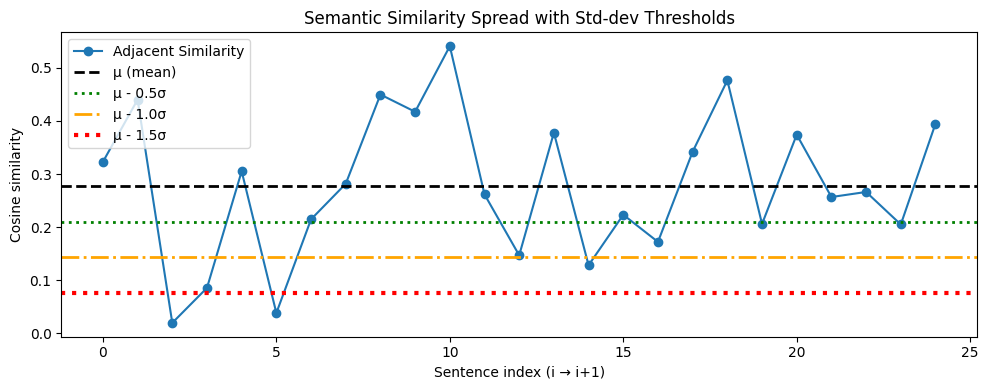

╭─ Similarity Statistics ─╮
│ Mean (μ): 0.2778        │
│ Std-dev (σ): 0.1349     │
│ k: 1.0                  │
│ Cutoff (μ - kσ): 0.1429 │
╰─────────────────────────╯

             Adjacent Similarities with Std-dev Rule             
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ μ - kσ ┃ Decision ┃ Reason           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S1 → S2   │     0.4403 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S2 → S3   │     0.0192 │ 0.1429 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S3 → S4   │     0.0852 │ 0.1429 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S4 → S5   │     0.3052 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S5 → S6   │     0.0378 │ 0.1429 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S6 → S7   │     0.2145 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S7 → S8   │     0.2816 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S8 → S9   │     0.4499 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S9 → S10  │     0.4174 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S10 → S11 │     0.5411 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S11 → S12 │     0.2616 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S12 → S13 │     0.1467 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S13 → S14 │     0.3779 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S14 → S15 │     0.1279 │ 0.1429 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S15 → S16 │     0.2231 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S16 → S17 │     0.1720 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S17 → S18 │     0.3420 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S18 → S19 │     0.4766 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S19 → S20 │     0.2057 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S20 → S21 │     0.3742 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S21 → S22 │     0.2566 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S22 → S23 │     0.2661 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S23 → S24 │     0.2048 │ 0.1429 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S24 → S25 │     0.3949 │ 0.1429 │ KEEP     │ within variance  │
└───────────┴────────────┴────────┴──────────┴──────────────────┘

╭──────────────────────────────────────────────────── Chunk 0 ────────────────────────────────────────────────────╮
│ MEDUSA                                                                                                          │
│ Jelly-fish                                                                                                      │
│ Whole face puffed œdematous-eyes, nose, ears, lips. Skin.––Numbness; burning, pricking heat. Vesicular eruption │
│ especially on face, arms, shoulders, and breasts.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 1 ─────────────╮
│ Nettlerash (Apis; Chloral; Dulc). │
╰───────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ Female.––Marked action on lacteal glands. The secretion of milk was established after lack of it in all         │
│ previous confinements.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 3 ────────────────────────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. MEL CUM SALE                        │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from      │
│ ileum to ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too     │
│ full. Pain from sacrum towards pubes. Pain as if in ureters. Dose.––Third to sixth potency. Honey for itching   │
│ of anus and worms. METHYLENUM COERULEUM                                                                         │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection.                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 4 ────────────────────────────────────────────────────╮
│ Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal nephritis. Urine         │
│ acquires a green color. Bladder irritation from its use antidoted by a little nutmeg. Surgical kidney with      │
│ large amount of pus in urine. Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states of apoplexy  │
│ (Gisevius). Dose.––3x attenuation. A 2 per cent solution locally, in chronic otitis with foul smelling          │
│ discharge. A 1 per cent aqueous solution for ulcers and abscesses of cornea.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [8]:
stddev_semantic_chunker(text)

#### Breakpoints should be relative to the document, not absolute numbers.

───────────────────────────────── Level 1 — Standard Deviation Semantic Chunking ──────────────────────────────────

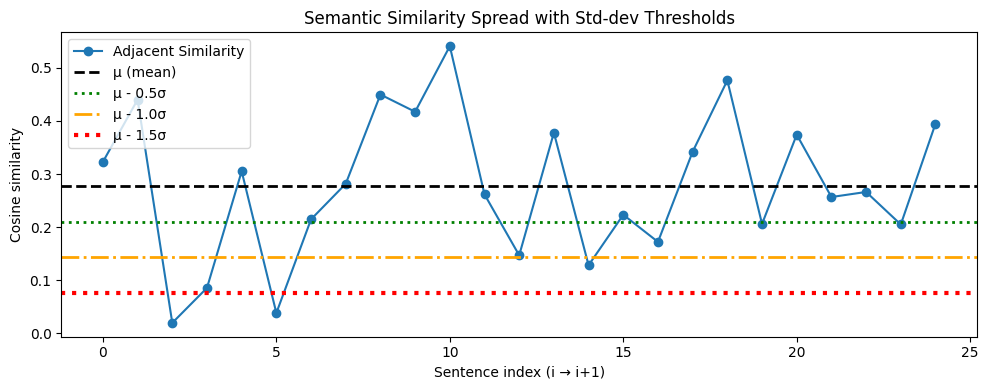

╭─ Similarity Statistics ─╮
│ Mean (μ): 0.2778        │
│ Std-dev (σ): 0.1349     │
│ k: 0.5                  │
│ Cutoff (μ - kσ): 0.2103 │
╰─────────────────────────╯

             Adjacent Similarities with Std-dev Rule             
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ μ - kσ ┃ Decision ┃ Reason           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S1 → S2   │     0.4403 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S2 → S3   │     0.0192 │ 0.2103 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S3 → S4   │     0.0852 │ 0.2103 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S4 → S5   │     0.3052 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S5 → S6   │     0.0378 │ 0.2103 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S6 → S7   │     0.2145 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S7 → S8   │     0.2816 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S8 → S9   │     0.4499 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S9 → S10  │     0.4174 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S10 → S11 │     0.5411 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S11 → S12 │     0.2616 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S12 → S13 │     0.1467 │ 0.2103 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S13 → S14 │     0.3779 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S14 → S15 │     0.1279 │ 0.2103 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S15 → S16 │     0.2231 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S16 → S17 │     0.1720 │ 0.2103 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S17 → S18 │     0.3420 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S18 → S19 │     0.4766 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S19 → S20 │     0.2057 │ 0.2103 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S20 → S21 │     0.3742 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S21 → S22 │     0.2566 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S22 → S23 │     0.2661 │ 0.2103 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S23 → S24 │     0.2048 │ 0.2103 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S24 → S25 │     0.3949 │ 0.2103 │ KEEP     │ within variance  │
└───────────┴────────────┴────────┴──────────┴──────────────────┘

╭──────────────────────────────────────────────────── Chunk 0 ────────────────────────────────────────────────────╮
│ MEDUSA                                                                                                          │
│ Jelly-fish                                                                                                      │
│ Whole face puffed œdematous-eyes, nose, ears, lips. Skin.––Numbness; burning, pricking heat. Vesicular eruption │
│ especially on face, arms, shoulders, and breasts.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 1 ─────────────╮
│ Nettlerash (Apis; Chloral; Dulc). │
╰───────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ Female.––Marked action on lacteal glands. The secretion of milk was established after lack of it in all         │
│ previous confinements.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 3 ────────────────────────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. MEL CUM SALE                        │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from      │
│ ileum to ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too     │
│ full. Pain from sacrum towards pubes. Pain as if in ureters. Dose.––Third to sixth potency.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 4 ────────────────────────────────────────────────────╮
│ Honey for itching of anus and worms. METHYLENUM COERULEUM                                                       │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection.                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── Chunk 5 ─────────────────────────────────────────────╮
│ Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal nephritis. │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 6 ────────────────────────────────────────────────────╮
│ Urine acquires a green color. Bladder irritation from its use antidoted by a little nutmeg. Surgical kidney     │
│ with large amount of pus in urine.                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 7 ────────────────────────────────────────────────────╮
│ Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states of apoplexy (Gisevius). Dose.––3x          │
│ attenuation.                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 8 ────────────────────────────────────────────────────╮
│ A 2 per cent solution locally, in chronic otitis with foul smelling discharge. A 1 per cent aqueous solution    │
│ for ulcers and abscesses of cornea.                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
stddev_semantic_chunker(text=text,k=0.5)

───────────────────────────────── Level 1 — Standard Deviation Semantic Chunking ──────────────────────────────────

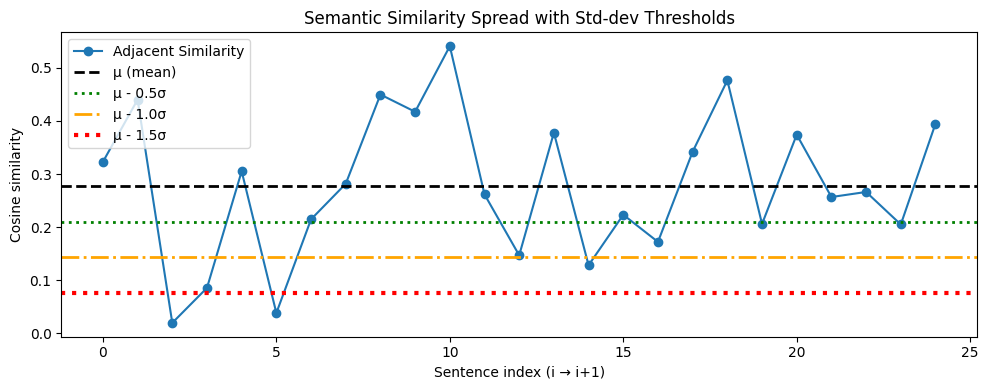

╭─ Similarity Statistics ─╮
│ Mean (μ): 0.2778        │
│ Std-dev (σ): 0.1349     │
│ k: 0.85                 │
│ Cutoff (μ - kσ): 0.1631 │
╰─────────────────────────╯

             Adjacent Similarities with Std-dev Rule             
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ μ - kσ ┃ Decision ┃ Reason           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S1 → S2   │     0.4403 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S2 → S3   │     0.0192 │ 0.1631 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S3 → S4   │     0.0852 │ 0.1631 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S4 → S5   │     0.3052 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S5 → S6   │     0.0378 │ 0.1631 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S6 → S7   │     0.2145 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S7 → S8   │     0.2816 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S8 → S9   │     0.4499 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S9 → S10  │     0.4174 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S10 → S11 │     0.5411 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S11 → S12 │     0.2616 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S12 → S13 │     0.1467 │ 0.1631 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S13 → S14 │     0.3779 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S14 → S15 │     0.1279 │ 0.1631 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S15 → S16 │     0.2231 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S16 → S17 │     0.1720 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S17 → S18 │     0.3420 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S18 → S19 │     0.4766 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S19 → S20 │     0.2057 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S20 → S21 │     0.3742 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S21 → S22 │     0.2566 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S22 → S23 │     0.2661 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S23 → S24 │     0.2048 │ 0.1631 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S24 → S25 │     0.3949 │ 0.1631 │ KEEP     │ within variance  │
└───────────┴────────────┴────────┴──────────┴──────────────────┘

╭──────────────────────────────────────────────────── Chunk 0 ────────────────────────────────────────────────────╮
│ MEDUSA                                                                                                          │
│ Jelly-fish                                                                                                      │
│ Whole face puffed œdematous-eyes, nose, ears, lips. Skin.––Numbness; burning, pricking heat. Vesicular eruption │
│ especially on face, arms, shoulders, and breasts.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 1 ─────────────╮
│ Nettlerash (Apis; Chloral; Dulc). │
╰───────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ Female.––Marked action on lacteal glands. The secretion of milk was established after lack of it in all         │
│ previous confinements.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 3 ────────────────────────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. MEL CUM SALE                        │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from      │
│ ileum to ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too     │
│ full. Pain from sacrum towards pubes. Pain as if in ureters. Dose.––Third to sixth potency.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 4 ────────────────────────────────────────────────────╮
│ Honey for itching of anus and worms. METHYLENUM COERULEUM                                                       │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection.                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 5 ────────────────────────────────────────────────────╮
│ Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal nephritis. Urine         │
│ acquires a green color. Bladder irritation from its use antidoted by a little nutmeg. Surgical kidney with      │
│ large amount of pus in urine. Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states of apoplexy  │
│ (Gisevius). Dose.––3x attenuation. A 2 per cent solution locally, in chronic otitis with foul smelling          │
│ discharge. A 1 per cent aqueous solution for ulcers and abscesses of cornea.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
stddev_semantic_chunker(text=text,k=0.85)

───────────────────────────────── Level 1 — Standard Deviation Semantic Chunking ──────────────────────────────────

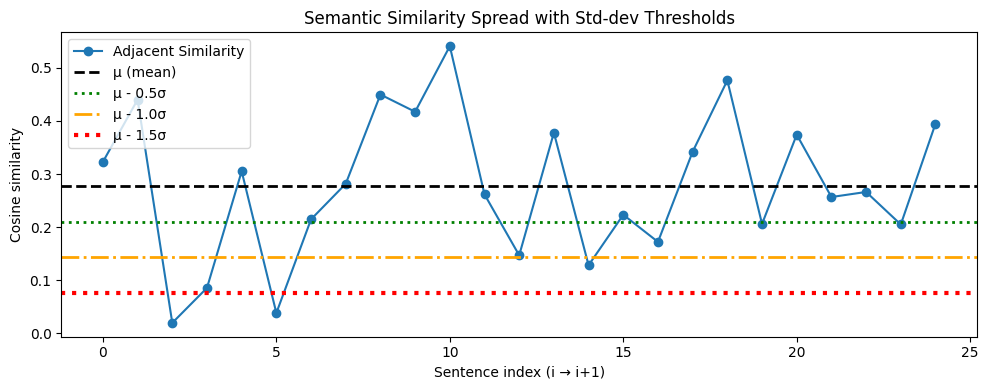

╭─ Similarity Statistics ─╮
│ Mean (μ): 0.2778        │
│ Std-dev (σ): 0.1349     │
│ k: 1.5                  │
│ Cutoff (μ - kσ): 0.0754 │
╰─────────────────────────╯

             Adjacent Similarities with Std-dev Rule             
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ μ - kσ ┃ Decision ┃ Reason           ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S1 → S2   │     0.4403 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S2 → S3   │     0.0192 │ 0.0754 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S3 → S4   │     0.0852 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S4 → S5   │     0.3052 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S5 → S6   │     0.0378 │ 0.0754 │ BREAK    │ statistical drop │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S6 → S7   │     0.2145 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S7 → S8   │     0.2816 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S8 → S9   │     0.4499 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S9 → S10  │     0.4174 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S10 → S11 │     0.5411 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S11 → S12 │     0.2616 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S12 → S13 │     0.1467 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S13 → S14 │     0.3779 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S14 → S15 │     0.1279 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S15 → S16 │     0.2231 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S16 → S17 │     0.1720 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S17 → S18 │     0.3420 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S18 → S19 │     0.4766 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S19 → S20 │     0.2057 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S20 → S21 │     0.3742 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S21 → S22 │     0.2566 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S22 → S23 │     0.2661 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S23 → S24 │     0.2048 │ 0.0754 │ KEEP     │ within variance  │
├───────────┼────────────┼────────┼──────────┼──────────────────┤
│ S24 → S25 │     0.3949 │ 0.0754 │ KEEP     │ within variance  │
└───────────┴────────────┴────────┴──────────┴──────────────────┘

╭──────────────────────────────────────────────────── Chunk 0 ────────────────────────────────────────────────────╮
│ MEDUSA                                                                                                          │
│ Jelly-fish                                                                                                      │
│ Whole face puffed œdematous-eyes, nose, ears, lips. Skin.––Numbness; burning, pricking heat. Vesicular eruption │
│ especially on face, arms, shoulders, and breasts.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 1 ────────────────────────────────────────────────────╮
│ Nettlerash (Apis; Chloral; Dulc). Female.––Marked action on lacteal glands. The secretion of milk was           │
│ established after lack of it in all previous confinements.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. MEL CUM SALE                        │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from      │
│ ileum to ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too     │
│ full. Pain from sacrum towards pubes. Pain as if in ureters. Dose.––Third to sixth potency. Honey for itching   │
│ of anus and worms. METHYLENUM COERULEUM                                                                         │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection. Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal           │
│ nephritis. Urine acquires a green color. Bladder irritation from its use antidoted by a little nutmeg. Surgical │
│ kidney with large amount of pus in urine. Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states  │
│ of apoplexy (Gisevius). Dose.––3x attenuation. A 2 per cent solution locally, in chronic otitis with foul       │
│ smelling discharge. A 1 per cent aqueous solution for ulcers and abscesses of cornea.                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
stddev_semantic_chunker(text=text,k=1.5)

#### k defines our choice of normal, aggressive, conservative chunking

### Percentile Based Semantic Chunking

In [23]:
def percentile_semantic_chunker(
    text: str,
    percentile: float = 90,
    model_name: str = "all-MiniLM-L6-v2",
):
    """
    Level 2 — Percentile-based Semantic Chunking
    No normalization. Cos(theta) computed explicitly.
    """

    console.rule("[bold green]Level 2 — Percentile Semantic Chunking")

    # ------------------------------------------------------------
    # Step 1: Sentence segmentation
    # ------------------------------------------------------------
    sentences = [
        s.strip()
        for s in re.split(r"(?<=[.!?])\s+", text)
        if s.strip()
    ]

    # ------------------------------------------------------------
    # Step 2: Embeddings (raw)
    # ------------------------------------------------------------
    model = SentenceTransformer(model_name)
    embeddings = model.encode(sentences)

    # ------------------------------------------------------------
    # Step 3: Adjacent cosine similarities
    # ------------------------------------------------------------
    similarities = []
    for i in range(len(embeddings) - 1):
        sim = cosine_similarity(embeddings[i], embeddings[i + 1])
        similarities.append(sim)

    similarities = np.array(similarities)

    

    # ------------------------------------------------------------
    # Step 4: Percentile threshold
    # ------------------------------------------------------------
    cutoff = np.percentile(similarities, 100 - percentile)

    plt.figure()
    plt.plot(similarities, marker="o")
    plt.axhline(cutoff)
    plt.xlabel("Adjacent Sentence Index (i → i+1)")
    plt.ylabel("Cosine Similarity")
    plt.title(f"Adjacent Similarities with {percentile}th Percentile Cutoff")
    plt.show()

    stats_panel = Panel(
        f"""
Percentile: {percentile}
Cutoff similarity (bottom {100 - percentile}%):
{cutoff:.4f}
""".strip(),
        title="Percentile Statistics",
        expand=False
    )
    console.print(stats_panel)

    # ------------------------------------------------------------
    # Step 5: Similarity + breakpoint table
    # ------------------------------------------------------------
    sim_table = Table(
        title="Adjacent Similarities (Percentile Rule)",
        show_lines=True
    )
    sim_table.add_column("Pair")
    sim_table.add_column("Similarity", justify="right")
    sim_table.add_column("Cutoff", justify="right")
    sim_table.add_column("Decision")
    sim_table.add_column("Reason")

    breakpoints = []

    for i, sim in enumerate(similarities):
        do_break = sim <= cutoff
        breakpoints.append(do_break)

        sim_table.add_row(
            f"S{i} → S{i+1}",
            f"{sim:.4f}",
            f"{cutoff:.4f}",
            "BREAK" if do_break else "KEEP",
            "lowest similarity bucket" if do_break else "above percentile"
        )

    console.print(sim_table)

    # ------------------------------------------------------------
    # Step 6: Chunk assembly
    # ------------------------------------------------------------
    chunks = []
    current = [sentences[0]]

    for i, brk in enumerate(breakpoints):
        if brk:
            chunks.append(" ".join(current))
            current = [sentences[i + 1]]
        else:
            current.append(sentences[i + 1])

    chunks.append(" ".join(current))

    # ------------------------------------------------------------
    # Step 7: Display final chunks
    # ------------------------------------------------------------
    for i, chunk in enumerate(chunks):
        console.print(
            Panel(
                chunk,
                title=f"Chunk {i}",
                expand=False
            )
        )

───────────────────────────────────── Level 2 — Percentile Semantic Chunking ──────────────────────────────────────

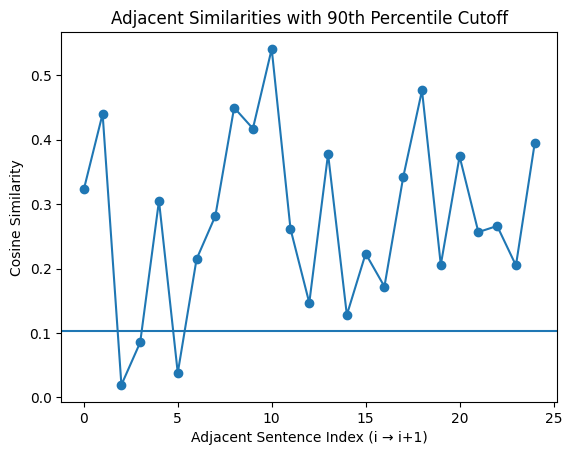

╭───── Percentile Statistics ─────╮
│ Percentile: 90                  │
│ Cutoff similarity (bottom 10%): │
│ 0.1023                          │
╰─────────────────────────────────╯

                 Adjacent Similarities (Percentile Rule)                 
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ Cutoff ┃ Decision ┃ Reason                   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S1 → S2   │     0.4403 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S2 → S3   │     0.0192 │ 0.1023 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S3 → S4   │     0.0852 │ 0.1023 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S4 → S5   │     0.3052 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S5 → S6   │     0.0378 │ 0.1023 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S6 → S7   │     0.2145 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S7 → S8   │     0.2816 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S8 → S9   │     0.4499 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S9 → S10  │     0.4174 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S10 → S11 │     0.5411 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S11 → S12 │     0.2616 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S12 → S13 │     0.1467 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S13 → S14 │     0.3779 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S14 → S15 │     0.1279 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S15 → S16 │     0.2231 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S16 → S17 │     0.1720 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S17 → S18 │     0.3420 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S18 → S19 │     0.4766 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S19 → S20 │     0.2057 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S20 → S21 │     0.3742 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S21 → S22 │     0.2566 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S22 → S23 │     0.2661 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S23 → S24 │     0.2048 │ 0.1023 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S24 → S25 │     0.3949 │ 0.1023 │ KEEP     │ above percentile         │
└───────────┴────────────┴────────┴──────────┴──────────────────────────┘

╭──────────────────────────────────────────────────── Chunk 0 ────────────────────────────────────────────────────╮
│ MEDUSA                                                                                                          │
│ Jelly-fish                                                                                                      │
│ Whole face puffed œdematous-eyes, nose, ears, lips. Skin.––Numbness; burning, pricking heat. Vesicular eruption │
│ especially on face, arms, shoulders, and breasts.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 1 ─────────────╮
│ Nettlerash (Apis; Chloral; Dulc). │
╰───────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ Female.––Marked action on lacteal glands. The secretion of milk was established after lack of it in all         │
│ previous confinements.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 3 ────────────────────────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. MEL CUM SALE                        │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from      │
│ ileum to ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too     │
│ full. Pain from sacrum towards pubes. Pain as if in ureters. Dose.––Third to sixth potency. Honey for itching   │
│ of anus and worms. METHYLENUM COERULEUM                                                                         │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection. Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal           │
│ nephritis. Urine acquires a green color. Bladder irritation from its use antidoted by a little nutmeg. Surgical │
│ kidney with large amount of pus in urine. Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states  │
│ of apoplexy (Gisevius). Dose.––3x attenuation. A 2 per cent solution locally, in chronic otitis with foul       │
│ smelling discharge. A 1 per cent aqueous solution for ulcers and abscesses of cornea.                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [24]:
percentile_semantic_chunker(text=text)

───────────────────────────────────── Level 2 — Percentile Semantic Chunking ──────────────────────────────────────

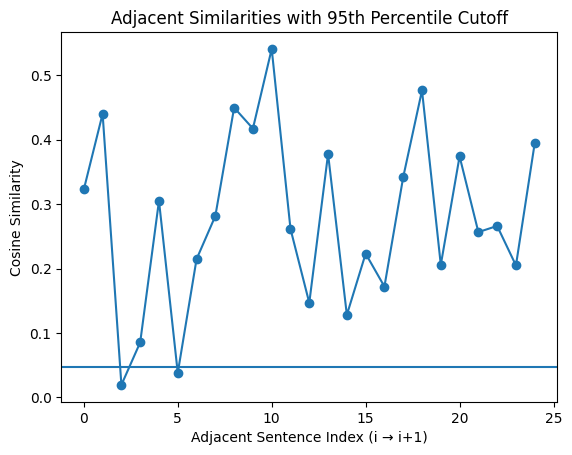

╭──── Percentile Statistics ─────╮
│ Percentile: 95                 │
│ Cutoff similarity (bottom 5%): │
│ 0.0473                         │
╰────────────────────────────────╯

                 Adjacent Similarities (Percentile Rule)                 
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ Cutoff ┃ Decision ┃ Reason                   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S1 → S2   │     0.4403 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S2 → S3   │     0.0192 │ 0.0473 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S3 → S4   │     0.0852 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S4 → S5   │     0.3052 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S5 → S6   │     0.0378 │ 0.0473 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S6 → S7   │     0.2145 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S7 → S8   │     0.2816 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S8 → S9   │     0.4499 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S9 → S10  │     0.4174 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S10 → S11 │     0.5411 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S11 → S12 │     0.2616 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S12 → S13 │     0.1467 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S13 → S14 │     0.3779 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S14 → S15 │     0.1279 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S15 → S16 │     0.2231 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S16 → S17 │     0.1720 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S17 → S18 │     0.3420 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S18 → S19 │     0.4766 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S19 → S20 │     0.2057 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S20 → S21 │     0.3742 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S21 → S22 │     0.2566 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S22 → S23 │     0.2661 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S23 → S24 │     0.2048 │ 0.0473 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S24 → S25 │     0.3949 │ 0.0473 │ KEEP     │ above percentile         │
└───────────┴────────────┴────────┴──────────┴──────────────────────────┘

╭──────────────────────────────────────────────────── Chunk 0 ────────────────────────────────────────────────────╮
│ MEDUSA                                                                                                          │
│ Jelly-fish                                                                                                      │
│ Whole face puffed œdematous-eyes, nose, ears, lips. Skin.––Numbness; burning, pricking heat. Vesicular eruption │
│ especially on face, arms, shoulders, and breasts.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 1 ────────────────────────────────────────────────────╮
│ Nettlerash (Apis; Chloral; Dulc). Female.––Marked action on lacteal glands. The secretion of milk was           │
│ established after lack of it in all previous confinements.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. MEL CUM SALE                        │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from      │
│ ileum to ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too     │
│ full. Pain from sacrum towards pubes. Pain as if in ureters. Dose.––Third to sixth potency. Honey for itching   │
│ of anus and worms. METHYLENUM COERULEUM                                                                         │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection. Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal           │
│ nephritis. Urine acquires a green color. Bladder irritation from its use antidoted by a little nutmeg. Surgical │
│ kidney with large amount of pus in urine. Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states  │
│ of apoplexy (Gisevius). Dose.––3x attenuation. A 2 per cent solution locally, in chronic otitis with foul       │
│ smelling discharge. A 1 per cent aqueous solution for ulcers and abscesses of cornea.                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [25]:
percentile_semantic_chunker(text=text,percentile=95)

───────────────────────────────────── Level 2 — Percentile Semantic Chunking ──────────────────────────────────────

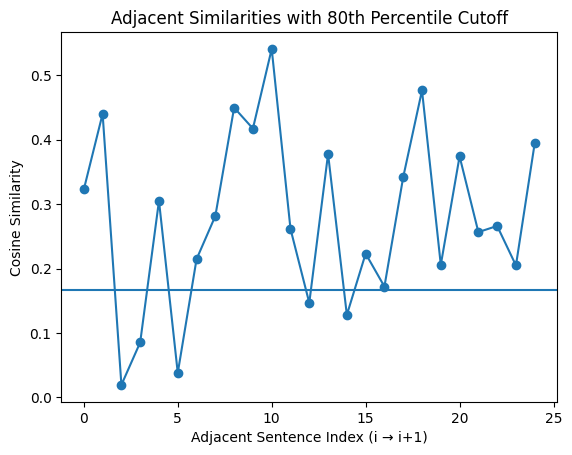

╭───── Percentile Statistics ─────╮
│ Percentile: 80                  │
│ Cutoff similarity (bottom 20%): │
│ 0.1669                          │
╰─────────────────────────────────╯

                 Adjacent Similarities (Percentile Rule)                 
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ Cutoff ┃ Decision ┃ Reason                   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S1 → S2   │     0.4403 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S2 → S3   │     0.0192 │ 0.1669 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S3 → S4   │     0.0852 │ 0.1669 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S4 → S5   │     0.3052 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S5 → S6   │     0.0378 │ 0.1669 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S6 → S7   │     0.2145 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S7 → S8   │     0.2816 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S8 → S9   │     0.4499 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S9 → S10  │     0.4174 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S10 → S11 │     0.5411 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S11 → S12 │     0.2616 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S12 → S13 │     0.1467 │ 0.1669 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S13 → S14 │     0.3779 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S14 → S15 │     0.1279 │ 0.1669 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S15 → S16 │     0.2231 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S16 → S17 │     0.1720 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S17 → S18 │     0.3420 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S18 → S19 │     0.4766 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S19 → S20 │     0.2057 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S20 → S21 │     0.3742 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S21 → S22 │     0.2566 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S22 → S23 │     0.2661 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S23 → S24 │     0.2048 │ 0.1669 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S24 → S25 │     0.3949 │ 0.1669 │ KEEP     │ above percentile         │
└───────────┴────────────┴────────┴──────────┴──────────────────────────┘

╭──────────────────────────────────────────────────── Chunk 0 ────────────────────────────────────────────────────╮
│ MEDUSA                                                                                                          │
│ Jelly-fish                                                                                                      │
│ Whole face puffed œdematous-eyes, nose, ears, lips. Skin.––Numbness; burning, pricking heat. Vesicular eruption │
│ especially on face, arms, shoulders, and breasts.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 1 ─────────────╮
│ Nettlerash (Apis; Chloral; Dulc). │
╰───────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ Female.––Marked action on lacteal glands. The secretion of milk was established after lack of it in all         │
│ previous confinements.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 3 ────────────────────────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. MEL CUM SALE                        │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from      │
│ ileum to ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too     │
│ full. Pain from sacrum towards pubes. Pain as if in ureters. Dose.––Third to sixth potency.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 4 ────────────────────────────────────────────────────╮
│ Honey for itching of anus and worms. METHYLENUM COERULEUM                                                       │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection.                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 5 ────────────────────────────────────────────────────╮
│ Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal nephritis. Urine         │
│ acquires a green color. Bladder irritation from its use antidoted by a little nutmeg. Surgical kidney with      │
│ large amount of pus in urine. Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states of apoplexy  │
│ (Gisevius). Dose.––3x attenuation. A 2 per cent solution locally, in chronic otitis with foul smelling          │
│ discharge. A 1 per cent aqueous solution for ulcers and abscesses of cornea.                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [26]:
percentile_semantic_chunker(text=text,percentile=80)

───────────────────────────────────── Level 2 — Percentile Semantic Chunking ──────────────────────────────────────

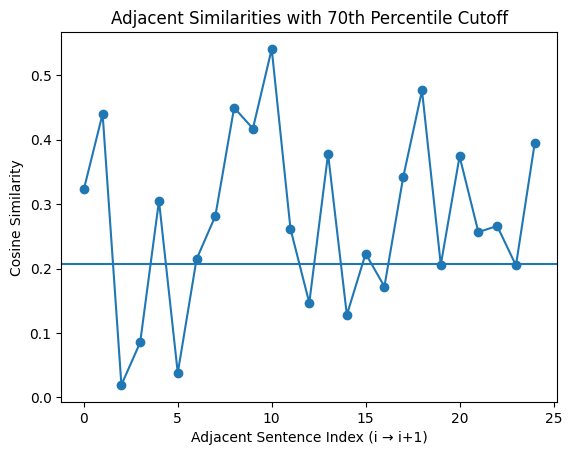

╭───── Percentile Statistics ─────╮
│ Percentile: 70                  │
│ Cutoff similarity (bottom 30%): │
│ 0.2075                          │
╰─────────────────────────────────╯

                 Adjacent Similarities (Percentile Rule)                 
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Pair      ┃ Similarity ┃ Cutoff ┃ Decision ┃ Reason                   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ S0 → S1   │     0.3228 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S1 → S2   │     0.4403 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S2 → S3   │     0.0192 │ 0.2075 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S3 → S4   │     0.0852 │ 0.2075 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S4 → S5   │     0.3052 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S5 → S6   │     0.0378 │ 0.2075 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S6 → S7   │     0.2145 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S7 → S8   │     0.2816 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S8 → S9   │     0.4499 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S9 → S10  │     0.4174 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S10 → S11 │     0.5411 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S11 → S12 │     0.2616 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S12 → S13 │     0.1467 │ 0.2075 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S13 → S14 │     0.3779 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S14 → S15 │     0.1279 │ 0.2075 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S15 → S16 │     0.2231 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S16 → S17 │     0.1720 │ 0.2075 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S17 → S18 │     0.3420 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S18 → S19 │     0.4766 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S19 → S20 │     0.2057 │ 0.2075 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S20 → S21 │     0.3742 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S21 → S22 │     0.2566 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S22 → S23 │     0.2661 │ 0.2075 │ KEEP     │ above percentile         │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S23 → S24 │     0.2048 │ 0.2075 │ BREAK    │ lowest similarity bucket │
├───────────┼────────────┼────────┼──────────┼──────────────────────────┤
│ S24 → S25 │     0.3949 │ 0.2075 │ KEEP     │ above percentile         │
└───────────┴────────────┴────────┴──────────┴──────────────────────────┘

╭──────────────────────────────────────────────────── Chunk 0 ────────────────────────────────────────────────────╮
│ MEDUSA                                                                                                          │
│ Jelly-fish                                                                                                      │
│ Whole face puffed œdematous-eyes, nose, ears, lips. Skin.––Numbness; burning, pricking heat. Vesicular eruption │
│ especially on face, arms, shoulders, and breasts.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────── Chunk 1 ─────────────╮
│ Nettlerash (Apis; Chloral; Dulc). │
╰───────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 2 ────────────────────────────────────────────────────╮
│ Female.––Marked action on lacteal glands. The secretion of milk was established after lack of it in all         │
│ previous confinements.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 3 ────────────────────────────────────────────────────╮
│ Relationship.––Compare: Pyrarara, Physalia (urticaria); Urtica, Homar, Sep. MEL CUM SALE                        │
│ Honey with Salt                                                                                                 │
│ Prolapsus uteri and chronic metritis, especially when associated with subinvolution and inflammation of the     │
│ cervix. The special symptom leading to its selection is a feeling of soreness across the hypogastrium from      │
│ ileum to ileum. Uterine displacements, and in the commencement of metritis Sensation as if bladder were too     │
│ full. Pain from sacrum towards pubes. Pain as if in ureters. Dose.––Third to sixth potency.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 4 ────────────────────────────────────────────────────╮
│ Honey for itching of anus and worms. METHYLENUM COERULEUM                                                       │
│ Aniline Dye                                                                                                     │
│ Methylene Blue                                                                                                  │
│ A remedy for neuralgia, neurasthenia, malaria; typhoid, here it diminishes the tympanites, delirium, and fever; │
│ pus infection.                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── Chunk 5 ─────────────────────────────────────────────╮
│ Tendency to tremor, chorea and epilepsy. Nephritis (acute parenchymatous), scarlatinal nephritis. │
╰───────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 6 ────────────────────────────────────────────────────╮
│ Urine acquires a green color. Bladder irritation from its use antidoted by a little nutmeg. Surgical kidney     │
│ with large amount of pus in urine.                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 7 ────────────────────────────────────────────────────╮
│ Gonorrhœal rheumatism and cystitis. Backache, sciatica. Later states of apoplexy (Gisevius). Dose.––3x          │
│ attenuation.                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────── Chunk 8 ────────────────────────────────────────────────────╮
│ A 2 per cent solution locally, in chronic otitis with foul smelling discharge. A 1 per cent aqueous solution    │
│ for ulcers and abscesses of cornea.                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [27]:
percentile_semantic_chunker(text=text,percentile=70)